# Exploring the spatial distributions of GCs in Abell 2744

* Photometric catalogue of GCs from Harris & Reina-Campos 2023
  - select GCs by quality zone, colour, ...


In [1]:
# Import modules
import sys, numpy, os, glob, scipy
import matplotlib.pyplot as plt
import matplotlib as mpl

# from matplotlib.ticker import ScalarFormatter
# import astropy
from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy import constants as c

# from astropy.cosmology import Planck18, z_at_value
from astropy.table import Table
from matplotlib.colors import LogNorm
from astropy.visualization.wcsaxes import add_scalebar
from astropy.coordinates import SkyCoord
import numpy.ma as ma

# sys.path.append("/Users/mreina/Documents/Science/000-Projects/git-repos/git_shapes_gcs_dm/")
# from functions_shapes import create_gcs_image

mpl.rcParams["text.usetex"] = False
mpl.rcParams["font.size"] = 18.0
mpl.rcParams["legend.fontsize"] = 16.0
# mpl.rcParams['savefig.dpi'] = 100

## Load the photometric catalogue of GCs

In [2]:
def load_gc_catalogue():
    # input path of the photometric catalogue
    inpath = os.path.join("..", "Harris23_Abell2744_GCs")
    ls_files = glob.glob(
        os.path.join(inpath, "2404_00_catalogue_GCs_A2744_originalmosaic_psky*")
    )

    # read the photometric catalogue -- frame: fk5
    gc_catalogue = Table.read(
        ls_files[0],
        format="ascii",
        names=(
            "RA [J2000]",
            "DEC [J2000]",
            "x[orig px]",
            "y[orig px]",
            "prob",
            "F115W",
            "F150W",
            "F200W",
            "sky",
            "sigsky",
        ),
        units=(u.deg, u.deg, "", "", "", "", "", "", "", ""),
    )
    # distance modulus
    DM = 41.06
    # K-corrections in the 3 bands for a redshift of 0.308
    K_F115 = 0.17
    K_F150 = 0.17
    K_F200 = 0.42
    # coordinates in physical units
    image_angular_size = 92  # pc per pixel
    gc_catalogue["x[orig kpc]"] = gc_catalogue["x[orig px]"] * image_angular_size / 1000
    gc_catalogue["y[orig kpc]"] = gc_catalogue["y[orig px]"] * image_angular_size / 1000
    # K-corrected apparent magnitudes
    gc_catalogue["F115W0"] = gc_catalogue["F115W"] + K_F115
    gc_catalogue["F150W0"] = gc_catalogue["F150W"] + K_F150
    gc_catalogue["F200W0"] = gc_catalogue["F200W"] + K_F200

    # K-corrected absolute magnitudes
    gc_catalogue["M_F115W0"] = gc_catalogue["F115W"] + K_F115 - DM
    gc_catalogue["M_F150W0"] = gc_catalogue["F150W"] + K_F150 - DM
    gc_catalogue["M_F200W0"] = gc_catalogue["F200W"] + K_F200 - DM

    # determine the four sky zones
    gc_catalogue["Zone"] = 0
    gc_catalogue["Zone"][numpy.log10(gc_catalogue["sigsky"]) <= 1.8] = 1
    gc_catalogue["Zone"][
        (numpy.log10(gc_catalogue["sigsky"]) > 1.8)
        * (numpy.log10(gc_catalogue["sigsky"]) <= 2.1)
    ] = 2
    gc_catalogue["Zone"][
        (numpy.log10(gc_catalogue["sigsky"]) > 2.1)
        * (numpy.log10(gc_catalogue["sigsky"]) <= 2.4)
    ] = 3
    gc_catalogue["Zone"][(numpy.log10(gc_catalogue["sigsky"]) > 2.4)] = 4

    # remove outliers in the colour distribution
    color = gc_catalogue["F115W0"] - gc_catalogue["F200W0"]
    mask = (color > -1.2) * (color < 1.2)
    # print(len(gc_catalogue), len(gc_catalogue[mask]))
    gc_catalogue = gc_catalogue[mask]

    return gc_catalogue


# luminosity distance to Abell2744
distance_to_a2744 = 1630 * u.Mpc
# from Harris & Reina-Campos 2023
arcsec_kpc = (
    2100 * u.kpc / (460 * u.arcsec)
)  # conversion between arcsec and kpc at the distance of Abell 2744

gc_catalogue = load_gc_catalogue()

# create the output path
out_path = os.path.join(".", "imgs", "spatial_distributions")
if not os.path.exists(out_path):
    os.makedirs(out_path)

## Load the convergence maps from the different lensing models

In [3]:
def load_lensing_model(
    do_lensing_model, do_surface_maps=False, distance_to_a2744=distance_to_a2744
):
    """Return the converenge map, its header and WCS for a given lensing model."""

    if do_lensing_model == "Furtak23":  # convergence map from Furtak+ 23
        # input path of the lensing model
        fname = glob.glob(
            os.path.join(
                os.path.join(
                    "..",
                    "LensingMap_A2744_Furtak23",
                    "Best-model_low-resolution_100mas",
                ),
                "*_kappa.fits",
            )
        )[0]
        if do_surface_maps:
            # normalized such that Dls/Ds = 1
            sigma_cr = (c.c.to("kpc/s") ** 2) / (
                4 * numpy.pi * c.G.to("kpc3 / (Msun s2)") * distance_to_a2744.to("kpc")
            )

    elif (
        do_lensing_model == "Cha24_WL"
    ):  # convergence map from Cha24 - only weak lensing constraints
        # input path of the lensing model
        fname = os.path.join(
            "..", "LensingMap_A2744_Cha24", "A2744_convergence_map_WL.fits"
        )
        if do_surface_maps:
            sigma_cr = (
                1.777e9 * u.solMass / u.kpc**2
            )  # solar mass per square kpc - critical surface density

    elif (
        do_lensing_model == "Cha24_SL_WL"
    ):  # convergence map from Cha24 - strong + weak lensing constraints
        # input path of the lensing model
        fname = os.path.join(
            "..", "LensingMap_A2744_Cha24", "A2744_convergence_map_SL_WL.fits"
        )
        if do_surface_maps:
            sigma_cr = (
                1.777e9 * u.solMass / u.kpc**2
            )  # solar mass per square kpc - critical surface density

    elif do_lensing_model == "Bergamini23":  # convergence map from Bergamini+23b
        # input path of the lensing model
        fname = os.path.join(
            "..", "LensingMap_A2744_Bergamini23", "kappa_B23_DlsDs1.fits"
        )
        if do_surface_maps:
            # solar mass per square kpc - critical surface density
            # normalized such that Dls/Ds = 1
            sigma_cr = (c.c.to("kpc/s") ** 2) / (
                4 * numpy.pi * c.G.to("kpc3 / (Msun s2)") * distance_to_a2744.to("kpc")
            )

    # open the header and the image
    with fits.open(fname, output_verify="fix") as fits_table:
        header = fits_table[0].header
        img = fits_table[0].data
        if do_surface_maps:
            img = img * sigma_cr
    # load the header in the correct WCS format
    wcs = WCS(header)

    return wcs, header, img

## Functions: number density maps of GCs and their smoothed counterparts

In [4]:
def create_number_density_gcs(x, y, number_of_pixels, lims_kpc=[[-1, 1], [-1, 1]]):
    """Function to calculate the number density maps of GCs given a 2d point distribution.
    Inputs:
    - x, y: coordinates of the GCs -- can be in kpc (projected physical size) or deg (RA, DEC)
    - number_of_pixels: number of pixels in the x and y directions
    - lims_kpc: limits of the image in kpc -- [[xmin, xmax], [ymin, ymax]]
    Output:
    - im_gcs_number: number density of GCs in the image in weights kpc^-2
    """

    # identify the units of the input coordinates
    if x.unit == u.kpc:
        x = x.to(u.kpc).value
        y = y.to(u.kpc).value
        do_units = "kpc"
    elif x.unit == u.deg:
        x = x.to(u.deg).value
        y = y.to(u.deg).value
        do_units = "deg"
    else:
        print("Units not recognized")

    # create the bins
    bins = [
        numpy.linspace(x.min(), x.max(), number_of_pixels + 1),
        numpy.linspace(y.min(), y.max(), number_of_pixels + 1),
    ]

    # calculate the width of a pixel - units: kpc
    width_per_pixel = [
        (lims_kpc[0][1] - lims_kpc[0][0]) / number_of_pixels,
        (lims_kpc[1][1] - lims_kpc[1][0]) / number_of_pixels,
    ]

    # create the 2d histogram
    img, xedges, yedges = numpy.histogram2d(
        x, y, bins=bins, weights=numpy.ones(shape=len(x))
    )
    if do_units == "deg":  # by convention, RA goes right to left
        img = numpy.flip(img, axis=0)
        xedges = numpy.flip(xedges, axis=0)
    img = img.transpose() + 1e-6  # add a small number to avoid division by zero

    # create the number density image of GCs - units: kpc^-2
    img /= width_per_pixel[0] * width_per_pixel[1]

    # return the image and the width per pixel
    return img, width_per_pixel, xedges, yedges


def create_smoothed_number_density_gcs(img, width_per_pixel, sigma_kpc):
    ### smooth the images with a gaussian kernel

    # kernel size in pixels
    mean_width_per_pixel = 0.5 * (width_per_pixel[0] + width_per_pixel[1])
    sigma_px = int(numpy.floor(sigma_kpc / mean_width_per_pixel))
    # GC number density
    smooth_img_gcs = scipy.ndimage.gaussian_filter(img, sigma_px)
    return smooth_img_gcs


def create_both_number_density_and_smoothed_maps_gcs(
    xx_units, yy_units, number_of_pixels, sigma_kpc, gc_catalogue, mask=None
):
    lims_kpc = [
        [
            gc_catalogue["x[orig kpc]"][mask].min(),
            gc_catalogue["x[orig kpc]"][mask].max(),
        ],
        [
            gc_catalogue["y[orig kpc]"][mask].min(),
            gc_catalogue["y[orig kpc]"][mask].max(),
        ],
    ]
    # create the number density image of GCs - units: kpc^-2
    img, width_per_pixel, xedges, yedges = create_number_density_gcs(
        xx_units[mask], yy_units[mask], number_of_pixels, lims_kpc
    )
    # smooth the images with a gaussian kernel
    smooth_img = create_smoothed_number_density_gcs(img, width_per_pixel, sigma_kpc)

    return img, smooth_img, xedges, yedges

### Single map: Furtak+23 + blue GCs

 [astropy.io.fits.verify]


Blue GCs 10575 3605


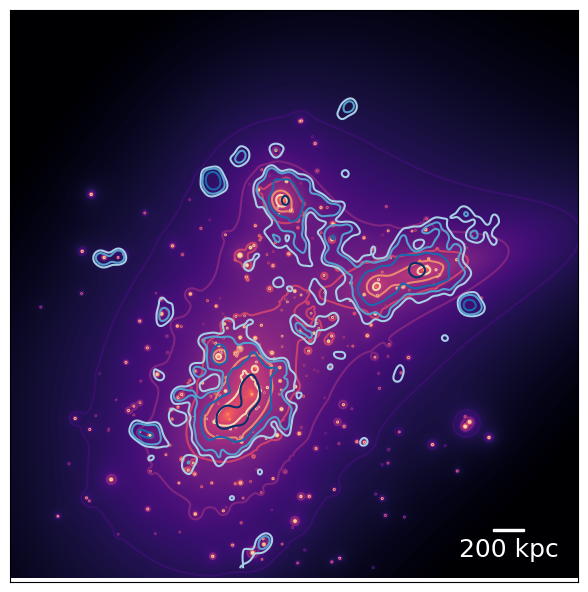

In [23]:
def figure_lensing_map_with_gcs_contours(
    img1,
    wcs1,
    xedges,
    yedges,
    coords_gcs,
    smooth_img,
    cmap1,
    color_gcs="Greys",
    label1="",
    label_gcs="",
    fname="",
):
    def add_panel_with_colorbar(ax, img, cmap, label="", lim_cbar=[0, 1]):
        cb = ax.imshow(
            img,
            origin="lower",
            cmap=cmap,
            norm=LogNorm(vmin=lim_cbar[0], vmax=lim_cbar[1]),
            zorder=0,
        )
        levels = [
            numpy.power(10, 8.3),
            numpy.power(10, 8.5),
            numpy.power(10, 8.7),
            numpy.power(10, 8.9),
            numpy.power(10, 9.1),
        ]
        colors = plt.get_cmap("magma")(numpy.linspace(0.2, 1, 5))
        ax.contour(img, levels=levels, colors=colors, alpha=0.8)
        ax.annotate(
            label,
            xy=(0.98, 0.98),
            ha="right",
            va="top",
            xycoords="axes fraction",
            color="white",
        )
        return cb

    # determine limits for the colorbar
    lim_cbar = [1e8, 1e10]

    fig = plt.figure(figsize=(8, 6.5))
    left = 0.1
    right = 0.87
    top = 0.98
    bottom = 0.1
    hspace = 0.2
    wspace = 0.05

    axs = []
    ax = fig.add_subplot(1, 1, 1, projection=wcs1)
    axs.append(ax)
    cb = add_panel_with_colorbar(ax, img1, cmap1, label=label1, lim_cbar=lim_cbar)

    # add the colorbar
    # cax = ax.inset_axes([1.01, 0., 0.02, 1.]) # [x0, y0, width, height]
    # create the colorbar object
    # cbar = fig.colorbar(cb, cax=cax, ax = axs[-1])
    # cbar.minorticks_on() # add minorticks
    # cbar.set_label(r"Projected mass surface density [$\rm M_{\odot}/kpc^2]$") # add label

    # prepare the coordinates and levels for the GC contours
    xbins = numpy.linspace(xedges[0], xedges[-1], len(xedges) - 1)
    ybins = numpy.linspace(yedges[0], yedges[-1], len(yedges) - 1)
    levels = [0.002, 0.003, 0.006, 0.02]  # 0.0005,
    colors = plt.get_cmap(color_gcs)(numpy.linspace(0.35, 1, 4))

    # format all axes
    for j, ax in enumerate(axs):
        # GC contours
        ax.contour(
            xbins,
            ybins,
            smooth_img,
            levels=levels,
            colors=colors,
            zorder=10,
            transform=ax.get_transform("fk5"),
        )
        ax.annotate(
            label_gcs,
            xy=(0.98, 0.02),
            ha="right",
            va="bottom",
            xycoords="axes fraction",
            color="white",
        )

        # Compute the angle corresponding to 10 pc at the distance of the galactic center
        scalebar_length = 200 * u.kpc
        scalebar_angle = (scalebar_length / distance_to_a2744).to(
            u.deg, equivalencies=u.dimensionless_angles()
        )
        # Add a scale bar
        add_scalebar(
            axs[-1], scalebar_angle, label="200 kpc", color="white", size_vertical=20
        )

        ra = ax.coords[0]
        dec = ax.coords[1]
        dec.set_ticks_visible(False)
        dec.set_ticklabel_visible(False)
        dec.set_axislabel("")
        ra.set_ticks_visible(False)
        ra.set_ticklabel_visible(False)
        ra.set_axislabel("")

    # format the entire figure
    fig.subplots_adjust(
        left=left, top=top, bottom=bottom, right=right, hspace=hspace, wspace=wspace
    )

    fig.savefig(
        os.path.join(
            out_path, "xy_lensing_map_with_gcs_furtak23_{:s}.png".format(fname)
        ),
        bbox_inches="tight",
    )
    plt.show()


#### FIRST - bright blue / red GCs
# convert the GCs celestial coordinates to pixel coordinates in the convergence map
coords_gcs = SkyCoord(
    ra=gc_catalogue["RA [J2000]"],
    dec=gc_catalogue["DEC [J2000]"],
    frame="fk5",
    distance=distance_to_a2744,
)

# load the lensing models
f23_wcs, f23_header, f23_img = load_lensing_model(
    "Furtak23", do_surface_maps=True, distance_to_a2744=distance_to_a2744
)

# show them side-by-side
# blue GCs
color = gc_catalogue["F115W0"] - gc_catalogue["F200W0"]
mask = (gc_catalogue["F150W"] < 29.5) * (color < 0)
print("Blue GCs", len(gc_catalogue), numpy.sum(mask))
number_of_pixels = 1024  # create the number density image of GCs - units: kpc^-2
sigma_kpc = 20  # kernel size in kpc

(
    img_gcs,
    smooth_img_gcs,
    xedges,
    yedges,
) = create_both_number_density_and_smoothed_maps_gcs(
    coords_gcs.ra.to(u.deg),
    coords_gcs.dec.to(u.deg),
    number_of_pixels,
    sigma_kpc,
    gc_catalogue,
    mask,
)

figure_lensing_map_with_gcs_contours(
    f23_img.value,
    f23_wcs,
    xedges,
    yedges,
    coords_gcs,
    smooth_img_gcs,
    "magma",
    color_gcs="Blues",
    fname="f150w29p5_blue",
)